In [7]:
% matplotlib inline

UsageError: Line magic function `%` not found.


In [8]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


# Model optimization

This example showcases how an NST based on model optimization can be performed in
``pystiche``. It closely follows the
`official PyTorch example <https://github.com/pytorch/examples/tree/master/fast_neural_style>`_
which in turn is based on :cite:`JAL2016`.


We start this example by importing everything we need and setting the device we will
be working on.



In [9]:
import contextlib
import os
import time
from collections import OrderedDict
from os import path

import torch
from torch import hub, nn
from torch.nn.functional import interpolate
from torchvision.utils import save_image
import torchvision.transforms as trans

import pystiche
from pystiche import demo, enc, loss, optim
from pystiche.image import show_image
from pystiche.misc import get_device

print(f"I'm working with pystiche=={pystiche.__version__}")

device = get_device()
print(f"I'm working with {device}")

I'm working with pystiche==1.0.1
I'm working with cuda


## Transformer

In contrast to image optimization, for model optimization we need to define a
transformer that, after it is trained, performs the stylization. In general different
architectures are possible (:cite:`JAL2016,ULVL2016`). For this example we use an
encoder-decoder architecture.

Before we define the transformer, we create some helper modules to reduce the clutter.



In the decoder we need to upsample the image. While it is possible to achieve this
with a :class:`~torch.nn.ConvTranspose2d`, it was found that traditional upsampling
followed by a standard convolution
`produces fewer artifacts <https://distill.pub/2016/deconv-checkerboard/>`_. Thus,
we create an module that wraps :func:`~torch.nn.functional.interpolate`.



In [10]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor=1.0, mode="nearest"):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, input):
        return interpolate(input, scale_factor=self.scale_factor, mode=self.mode, )

    def extra_repr(self):
        extras = []
        if self.scale_factor:
            extras.append(f"scale_factor={self.scale_factor}")
        if self.mode != "nearest":
            extras.append(f"mode={self.mode}")
        return ", ".join(extras)

For the transformer architecture we will be using, we need to define a convolution
module with some additional capabilities. In particular, it needs to be able to
- optionally upsample the input,
- pad the input in order for the convolution to be size-preserving,
- optionally normalize the output, and
- optionally pass the output through an activation function.

<div class="alert alert-info"><h4>Note</h4><p>Instead of :class:`~torch.nn.BatchNorm2d` we use :class:`~torch.nn.InstanceNorm2d`
  to normalize the output since it gives better results for NST :cite:`UVL2016`.</p></div>



In [11]:
class Conv(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            upsample=False,
            norm=True,
            activation=True,
    ):
        super().__init__()
        self.upsample = Interpolate(scale_factor=stride) if upsample else None
        self.pad = nn.ReflectionPad2d(kernel_size // 2)
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=1 if upsample else stride
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if norm else None
        self.activation = nn.ReLU() if activation else None

    def forward(self, input):
        if self.upsample:
            input = self.upsample(input)

        output = self.conv(self.pad(input))

        if self.norm:
            output = self.norm(output)
        if self.activation:
            output = self.activation(output)

        return output

It is common practice to append a few residual blocks after the initial convolutions
to the encoder to enable it to learn more descriptive features.



In [12]:
class Residual(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = Conv(channels, channels, kernel_size=3)
        self.conv2 = Conv(channels, channels, kernel_size=3, activation=False)

    def forward(self, input):
        output = self.conv2(self.conv1(input))
        return output + input

It can be useful for the training to transform the input into another value range,
for example from $\closedinterval{0}{1}$ to $\closedinterval{0}{255}$.



In [13]:
class FloatToUint8Range(nn.Module):
    def forward(self, input):
        return input * 255.0


class Uint8ToFloatRange(nn.Module):
    def forward(self, input):
        return input / 255.0

Finally, we can put all pieces together.

<div class="alert alert-info"><h4>Note</h4><p></p></div>

 You can access this transformer through :func:`pystiche.demo.transformer`.



In [14]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            Conv(3, 32, kernel_size=9),
            Conv(32, 64, kernel_size=3, stride=2),
            Conv(64, 128, kernel_size=3, stride=2),
            Residual(128),
            Residual(128),
            Residual(128),
            Residual(128),
            Residual(128),
        )
        self.decoder = nn.Sequential(
            Conv(128, 64, kernel_size=3, stride=2, upsample=True),
            Conv(64, 32, kernel_size=3, stride=2, upsample=True),
            Conv(32, 3, kernel_size=9, norm=False, activation=False),
        )

        self.preprocessor = FloatToUint8Range()
        self.postprocessor = Uint8ToFloatRange()

    def forward(self, input):
        input = self.preprocessor(input)
        output = self.decoder(self.encoder(input))
        return self.postprocessor(output)


transformer = Transformer().to(device)
print(transformer)

Transformer(
  (encoder): Sequential(
    (0): Conv(
      (pad): ReflectionPad2d((4, 4, 4, 4))
      (conv): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
      (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (activation): ReLU()
    )
    (1): Conv(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (activation): ReLU()
    )
    (2): Conv(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (activation): ReLU()
    )
    (3): Residual(
      (conv1): Conv(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (norm): InstanceNorm2d(128, eps=1e-05, mo

## Perceptual loss

Although model optimization is a different paradigm, the ``perceptual_loss`` is the
same as for image optimization.

<div class="alert alert-info"><h4>Note</h4><p></p></div>

 In some implementations, such as the PyTorch example and :cite:`JAL2016`, one can
 observe that the :func:`~pystiche.gram_matrix`, used as style representation, is not
 only normalized by the height and width of the feature map, but also by the number
 of channels. If used together with a :func:`~torch.nn.functional.mse_loss`, the
 normalization is performed twice. While this is unintended, it affects the training.
 In order to keep the other hyper parameters on par with the PyTorch example, we also
 adopt this change here.



In [15]:
multi_layer_encoder = enc.vgg16_multi_layer_encoder()

content_layer = "relu2_2"
content_encoder = multi_layer_encoder.extract_encoder(content_layer)
content_weight = 1e5
content_loss = loss.FeatureReconstructionLoss(
    content_encoder, score_weight=content_weight
)


class GramOperator(loss.GramLoss):
    def enc_to_repr(self, enc: torch.Tensor) -> torch.Tensor:
        repr = super().enc_to_repr(enc)
        num_channels = repr.size()[1]
        return repr / num_channels


style_layers = ("relu1_2", "relu2_2", "relu3_3", "relu4_3")
style_weight = 1e10
style_loss = loss.MultiLayerEncodingLoss(
    multi_layer_encoder,
    style_layers,
    lambda encoder, layer_weight: GramOperator(encoder, score_weight=layer_weight),
    layer_weights="sum",
    score_weight=style_weight,
)

perceptual_loss = loss.PerceptualLoss(content_loss, style_loss)
perceptual_loss = perceptual_loss.to(device)
print(perceptual_loss)

PerceptualLoss(
  (content_loss): FeatureReconstructionLoss(
    score_weight=100000
    (encoder): VGGMultiLayerEncoder(layer=relu2_2, arch=vgg16, framework=torch)
  )
  (style_loss): MultiLayerEncodingLoss(
    encoder=VGGMultiLayerEncoder(arch=vgg16, framework=torch), score_weight=1e+10
    (relu1_2): GramOperator()
    (relu2_2): GramOperator()
    (relu3_3): GramOperator()
    (relu4_3): GramOperator()
  )
)


## Training

In a first step we load the style image that will be used to train the
``transformer``.



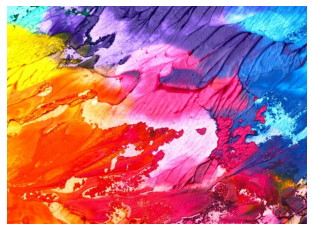

In [16]:
images = demo.images()
size = 500

style_image = images["paint"].read(size=size, device=device)
show_image(style_image)

The training of the ``transformer`` is performed similar to other models in PyTorch.
In every optimization step a batch of content images is drawn from a dataset, which
serve as input for the transformer as well as ``content_image`` for the
``perceptual_loss``. While the ``style_image`` only has to be set once, the
``content_image`` has to be reset in every iteration step.

While this can be done with a boilerplate optimization loop, ``pystiche`` provides
:func:`~pystiche.optim.multi_epoch_model_optimization` that handles the above for you.

<div class="alert alert-info"><h4>Note</h4><p>If the ``perceptual_loss`` is a :class:`~pystiche.loss.PerceptualLoss`, as is the
  case here, the update of the ``content_image`` is performed automatically. If that
  is not the case or you need more complex update behavior, you need to specify a
  ``criterion_update_fn``.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>If you do not specify an ``optimizer``, the
  :func:`~pystiche.optim.default_model_optimizer`, i.e. :class:`~torch.optim.Adam` is
  used.</p></div>



In [17]:
def train(
        transformer, dataset, batch_size=4, epochs=2,
):
    if dataset is None:
        raise RuntimeError(
            "You forgot to define a dataset. For example, "
            "you can use any image dataset from torchvision.datasets."
        )

    from torch.utils.data import DataLoader

    image_loader = DataLoader(dataset, batch_size=batch_size)

    perceptual_loss.set_style_image(style_image)

    return optim.multi_epoch_model_optimization(
        image_loader, transformer.train(), perceptual_loss, epochs=epochs,
    )

Depending on the dataset and your setup the training can take a couple of hours. To
avoid this, we provide transformer weights that were trained with the scheme above.

<div class="alert alert-info"><h4>Note</h4><p>If you want to perform the training yourself, set
  ``use_pretrained_transformer=False``. If you do, you also need to replace
  ``dataset = None`` below with the dataset you want to train on.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>The weights of the provided transformer were trained with the
  `2014 training images <http://images.cocodataset.org/zips/train2014.zip>`_ of the
  `COCO dataset <https://cocodataset.org/>`_. The training was performed for
  ``num_epochs=2`` and ``batch_size=4``. Each image was center-cropped to
  ``256 x 256`` pixels.</p></div>



In [18]:
use_pretrained_transformer = True
checkpoint = "example_transformer.pth"

if use_pretrained_transformer:
    if path.exists(checkpoint):
        state_dict = torch.load(checkpoint)
    else:
        # Unfortunately, torch.hub.load_state_dict_from_url has no option to disable
        # printing the downloading process. Since this would clutter the output, we
        # suppress it completely.
        @contextlib.contextmanager
        def suppress_output():
            with open(os.devnull, "w") as devnull:
                with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(
                        devnull
                ):
                    yield


        url = "https://download.pystiche.org/models/example_transformer.pth"

        with suppress_output():
            state_dict = hub.load_state_dict_from_url(url)

    transformer.load_state_dict(state_dict)
else:
    dataset = None
    transformer = train(transformer, dataset)

    state_dict = OrderedDict(
        [
            (name, parameter.detach().cpu())
            for name, parameter in transformer.state_dict().items()
        ]
    )
    torch.save(state_dict, checkpoint)

## Neural Style Transfer

In order to perform the NST, we load an image we want to stylize.



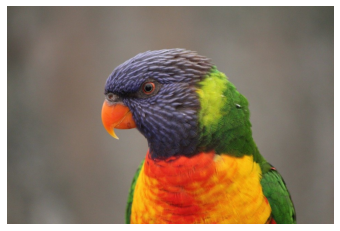

<class 'torch.Tensor'>
torch.Size([1, 3, 500, 750])
tensor([[[[0.3373, 0.3373, 0.3412,  ..., 0.3255, 0.3216, 0.3216],
          [0.3373, 0.3373, 0.3412,  ..., 0.3098, 0.3176, 0.3255],
          [0.3451, 0.3490, 0.3490,  ..., 0.3176, 0.3176, 0.3216],
          ...,
          [0.4039, 0.4039, 0.4039,  ..., 0.4667, 0.4667, 0.4627],
          [0.4118, 0.4118, 0.4039,  ..., 0.4471, 0.4588, 0.4667],
          [0.4000, 0.4039, 0.4039,  ..., 0.4627, 0.4627, 0.4627]],

         [[0.3294, 0.3294, 0.3333,  ..., 0.3176, 0.3137, 0.3137],
          [0.3294, 0.3294, 0.3333,  ..., 0.3059, 0.3137, 0.3216],
          [0.3373, 0.3412, 0.3412,  ..., 0.3176, 0.3176, 0.3216],
          ...,
          [0.3686, 0.3686, 0.3686,  ..., 0.4275, 0.4196, 0.4118],
          [0.3725, 0.3725, 0.3647,  ..., 0.4078, 0.4118, 0.4157],
          [0.3608, 0.3647, 0.3647,  ..., 0.4235, 0.4157, 0.4118]],

         [[0.2824, 0.2824, 0.2863,  ..., 0.2706, 0.2667, 0.2667],
          [0.2824, 0.2824, 0.2863,  ..., 0.2588, 0.2667,

In [19]:
input_image = images["bird1"].read(size=size, device=device)
show_image(input_image)
print(type(input_image))
print(input_image.size())
print(input_image)

After the transformer is trained we can now perform an NST with a single forward pass.
To do this, the ``transformer`` is simply called with the ``input_image``.



In [20]:
def perform_nst(input_image):
    transformer.eval()
    start = time.time()
    with torch.no_grad():
        output_image = transformer(input_image)
    stop = time.time()
    show_image(output_image, title="Output image")
    print(f"The stylization took {(stop - start) * 1e3:.0f} milliseconds.")
    return output_image

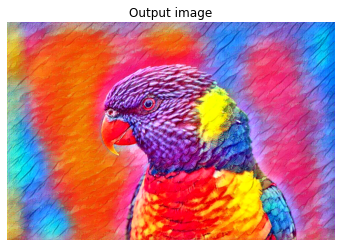

The stylization took 2627 milliseconds.


In [21]:
output_image = perform_nst(input_image)

In [22]:
from pystiche.image.io import export_to_pil

print(f'Type: {type(output_image)}')
print(f'Size: {output_image.size()}')
print(output_image)

# transform = trans.ToPILImage()
# pil_img = transform(output_image.squeeze(0)).convert('RGB')


# pil_img = export_to_pil(output_image)
# pil_img.show()

Type: <class 'torch.Tensor'>
Size: torch.Size([1, 3, 500, 752])
tensor([[[[ 0.7041,  0.5738,  0.6382,  ..., -0.0690, -0.1562, -0.0867],
          [ 0.7190,  0.5884,  0.6191,  ...,  0.0483,  0.0226,  0.0913],
          [ 0.7064,  0.5784,  0.6325,  ...,  0.0690,  0.1460,  0.1228],
          ...,
          [ 0.9616,  0.6598,  0.6745,  ...,  0.6090,  0.6482,  0.6516],
          [ 1.0438,  0.7627,  0.7401,  ...,  0.6791,  0.6850,  0.6827],
          [ 1.0961,  0.8117,  0.7880,  ...,  0.6691,  0.6969,  0.7017]],

         [[ 0.6578,  0.6535,  0.6407,  ...,  0.3499,  0.3176,  0.3806],
          [ 0.7060,  0.6995,  0.6958,  ...,  0.2601,  0.2793,  0.3555],
          [ 0.7433,  0.7450,  0.7779,  ...,  0.3238,  0.4333,  0.4710],
          ...,
          [ 0.6426,  0.6712,  0.6835,  ...,  0.4945,  0.4553,  0.4199],
          [ 0.5974,  0.6410,  0.6399,  ...,  0.4689,  0.4099,  0.3824],
          [ 0.5612,  0.5948,  0.5851,  ...,  0.4412,  0.4031,  0.3894]],

         [[ 0.5645,  0.7126,  0.6593, 

In [ ]:
save_image(output_image, 'out.png')

Compared to NST via image optimization, the stylization is performed multiple orders
of magnitudes faster. Given capable hardware, NST via model optimization enables
real-time stylization for example of a video feed.



<class 'torch.Tensor'>
torch.Size([1, 3, 432, 635])
tensor([[[[0.9569, 0.9529, 0.9569,  ..., 0.9686, 0.9647, 0.9608],
          [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9647],
          [0.9569, 0.9608, 0.9569,  ..., 0.9686, 0.9647, 0.9647],
          ...,
          [0.9333, 0.9294, 0.9333,  ..., 0.9725, 0.9765, 0.9843],
          [0.9333, 0.9333, 0.9333,  ..., 0.9765, 0.9804, 0.9843],
          [0.9333, 0.9373, 0.9333,  ..., 0.9804, 0.9804, 0.9843]],

         [[0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9294],
          [0.9255, 0.9255, 0.9216,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9294, 0.9255,  ..., 0.9255, 0.9255, 0.9294],
          ...,
          [0.8745, 0.8706, 0.8745,  ..., 0.9529, 0.9490, 0.9490],
          [0.8745, 0.8745, 0.8745,  ..., 0.9451, 0.9451, 0.9490],
          [0.8745, 0.8784, 0.8745,  ..., 0.9451, 0.9451, 0.9490]],

         [[0.8745, 0.8745, 0.8745,  ..., 0.8784, 0.8784, 0.8784],
          [0.8745, 0.8745, 0.8784,  ..., 0.8784, 0.8784,

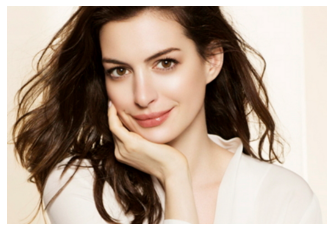

In [23]:
from pystiche.image.io import read_image, import_from_pil
from PIL import Image

# image = Image.open('original.jpg')
# # image.show()
# image = trans.PILToTensor()(image).unsqueeze(0)
# # image = image.unsqueeze(0)
# # print(image)
# show_image(image)

# input_image2 = read_image('../1/img/original.jpg', device=device)
input_image2 = Image.open('../1/img/original.jpg')
input_image2 = import_from_pil(input_image2, device=device, make_batched=True)
print(type(input_image2))
print(input_image2.size())
print(input_image2)
show_image(input_image2)


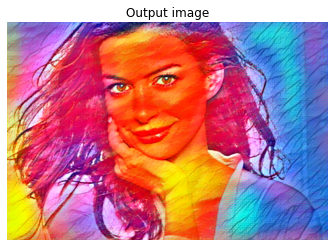

The stylization took 13 milliseconds.


In [24]:
output_image2 = perform_nst(input_image2)

### Mediapipe

In [25]:
import cv2
import mediapipe as mp
import numpy as np


mp_drawing = mp.solutions.drawing_utils
mp_selfie_segmentation = mp.solutions.selfie_segmentation

In [48]:
numpy_image = np.array(Image.open('../1/img/original.jpg'))

cv2.imshow('image', cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

(432, 635, 3)
[[[244 236 223]
  [243 236 223]
  [244 236 223]
  ...
  [247 236 224]
  [246 236 224]
  [245 237 224]]

 [[244 236 223]
  [244 236 223]
  [244 235 224]
  ...
  [247 236 224]
  [247 236 224]
  [246 236 224]]

 [[244 236 223]
  [245 237 224]
  [244 236 223]
  ...
  [247 236 224]
  [246 236 224]
  [246 237 224]]

 ...

 [[238 223 204]
  [237 222 203]
  [238 223 204]
  ...
  [248 243 233]
  [249 242 233]
  [251 242 233]]

 [[238 223 204]
  [238 223 204]
  [238 223 204]
  ...
  [249 241 230]
  [250 241 232]
  [251 242 233]]

 [[238 223 204]
  [239 224 205]
  [238 223 204]
  ...
  [250 241 231]
  [250 241 231]
  [251 242 232]]]


In [29]:
cv2.imshow('image', cv2.cvtColor(input_image2.cpu()[0].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [39]:
# bg_image = cv2.imread('../image_preprocessing/this_is_fine.jpeg')
BG_COLOR = (255, 255, 255)

with mp_selfie_segmentation.SelfieSegmentation(model_selection=0) as selfie_segmentation:
    image = input_image2.cpu()[0].permute(1, 2, 0).numpy()
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image_height, image_width, _ = image.shape
    # bg_image = cv2.resize(bg_image, (image_width, image_height))

    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    results = selfie_segmentation.process(image)

    # Draw selfie segmentation on the background image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((cv2.blur(results.segmentation_mask, (5, 5)),) * 3, axis=-1) > 0.6

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output_image = np.where(condition, image, bg_image)
    cv2.imwrite('selfie_segmentation_output' + '0' + '.png', output_image)

### PILLOW -> MEDIAPIPE -> NST -> PILLOW

In [40]:
original_image = Image.open('../1/img/original.jpg')


### Other images

In [19]:
print(images)

DownloadableImageCollection(
  (bird1): DownloadableImage(
    file=bird1.jpg,
    note=https://pixabay.com/photos/bird-wildlife-australian-bird-1139734/,
    url=https://download.pystiche.org/images/bird1.jpg,
    title=unknown,
    author=gholmz0,
    date=09.03.2013,
    license=Pixabay (https://pixabay.com/service/license/)
  )
  (paint): DownloadableImage(
    file=paint.jpg,
    note=https://pixabay.com/de/photos/abstrakt-kunst-hintergrund-farbe-2468874/,
    url=https://download.pystiche.org/images/paint.jpg,
    title=unknown,
    author=garageband,
    date=03.07.2017,
    license=Pixabay (https://pixabay.com/service/license/)
  )
  (bird2): DownloadableImage(
    file=bird2.jpg,
    note=https://pixabay.com/photos/bird-wildlife-sky-clouds-nature-92956/,
    url=https://download.pystiche.org/images/bird2.jpg,
    title=unknown,
    author=12019,
    date=09.04.2012,
    license=Pixabay (https://pixabay.com/service/license/)
  )
  (mosaic): DownloadableImage(
    file=mosaic.jp

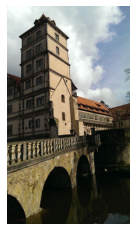

In [30]:
img = images["castle"].read(size=size, device=device)
show_image(img)

In [32]:
save_image(img, 'in.png')

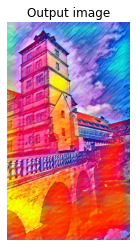

The stylization took 34 milliseconds.


In [27]:
out = perform_nst(img)

In [31]:
save_image(out, 'out2.png')

### Local images

In [67]:
import torchvision
from PIL import Image

In [69]:
def transform_to_pillow_image(tensor_image) -> Image.Image:
    grid = torchvision.utils.make_grid(tensor_image)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    return Image.fromarray(ndarr)

In [20]:
from PIL import Image
from torchvision import transforms

In [ ]:
device = torch.device('cpu')
transformer.to(device)
my_img = Image.open('ja.JPG')
my_img_tensor = transforms.ToTensor()(my_img)
my_img_tensor = my_img_tensor.unsqueeze(0).to(device)
show_image(my_img_tensor)

In [ ]:
my_img_out = perform_nst(my_img_tensor)

In [63]:
pil_image = transforms.ToPILImage()(my_img_out[0])

In [66]:
pil_image.save('dupa.jpg')

In [70]:
p_image = transform_to_pillow_image(my_img_out)
p_image.save('cipa.jpg')

In [54]:
save_image(my_img_out, 'ja_nst.jpg')

In [57]:
img.size()

torch.Size([1, 3, 885, 500])

In [60]:
if len(list(img.size())) == 4:
    print('yeah')

yeah


In [39]:
img[0][2]

tensor([[0.8980, 0.9216, 0.9412,  ..., 0.6471, 0.6431, 0.6510],
        [0.9216, 0.9373, 0.9451,  ..., 0.6510, 0.6471, 0.6627],
        [0.9451, 0.9490, 0.9490,  ..., 0.6510, 0.6549, 0.6706],
        ...,
        [0.0471, 0.0431, 0.0392,  ..., 0.1490, 0.1451, 0.1098],
        [0.0431, 0.0392, 0.0314,  ..., 0.1294, 0.1216, 0.0706],
        [0.0392, 0.0353, 0.0275,  ..., 0.0941, 0.0745, 0.0196]],
       device='cuda:0')